In [ ]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors
100% 1.52G/1.52G [00:17<00:00, 130MB/s]
100% 1.52G/1.52G [00:17<00:00, 94.0MB/s]


In [ ]:
!unzip -q /content/ct-kidney-dataset-normal-cyst-tumor-and-stone.zip -d /content/

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


In [ ]:
data_path = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/"

images = []
labels = []

for subfolder in os.listdir(data_path):

    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        labels.append(subfolder)

data = pd.DataFrame({'image': images, 'label': labels})

In [ ]:
data.head()

,image,label
0,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Tumor
1,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Tumor
2,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Tumor
3,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Tumor
4,/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...,Tumor


In [ ]:
data.shape

(12446, 2)

In [ ]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [ ]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (9956, 2)
Validation set shape: (1245, 2)
Test set shape: (1245, 2)


In [ ]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 9956 validated image filenames belonging to 4 classes.
Found 1245 validated image filenames belonging to 4 classes.
Found 1245 validated image filenames belonging to 4 classes.


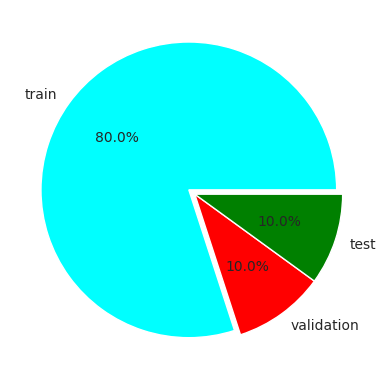

In [ ]:
plt.pie([len(train_gen), len(valid_gen), len(test_gen)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['aqua', 'red', 'green'], explode=(0.05, 0, 0))
plt.show()

In [ ]:
print(train_gen.class_indices)
print(test_gen.class_indices)
print(valid_gen.class_indices)

{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}
{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}
{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}


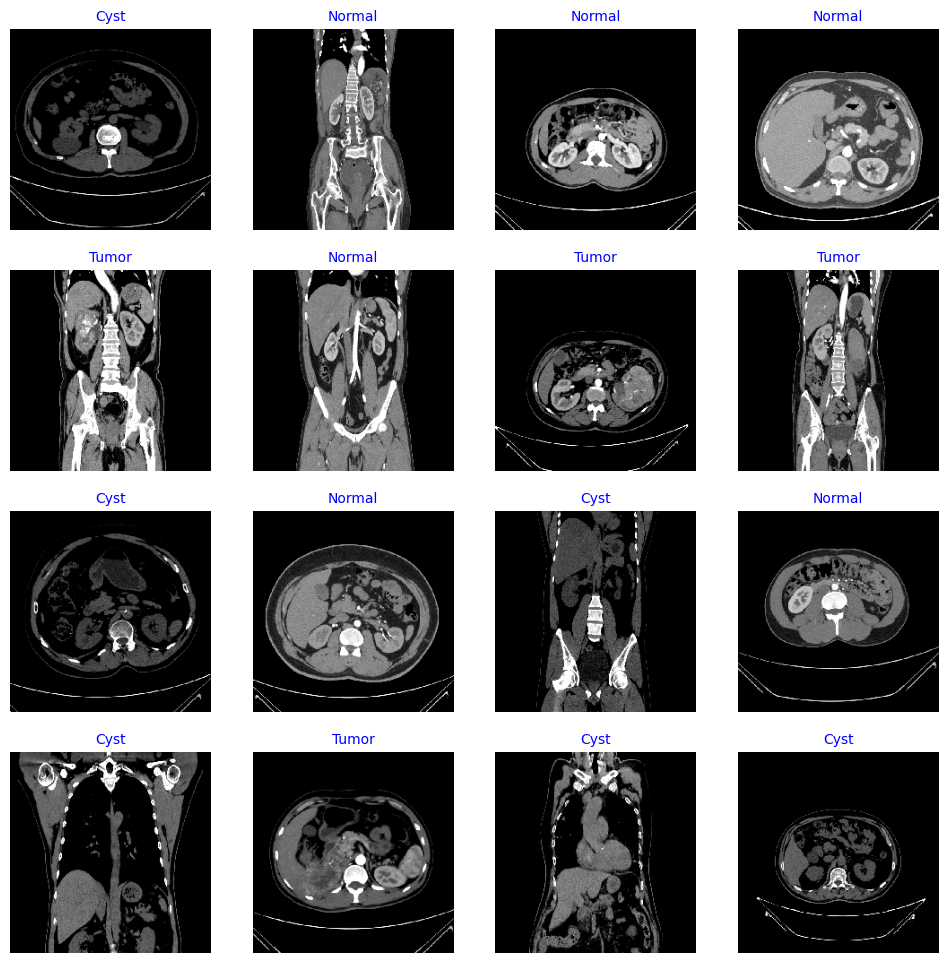

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

In [ ]:
from keras.applications import VGG16
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = vgg16_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
vgg16_model = Model(inputs, outputs)

vgg16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history3 = vgg16_model.fit(train_gen, epochs=8, validation_data=valid_gen)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 87s 223ms/step - accuracy: 0.6064 - loss: 1.7865 - val_accuracy: 0.9229 - val_loss: 0.2570
Epoch 2/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 115s 184ms/step - accuracy: 0.8438 - loss: 0.4101 - val_accuracy: 0.9695 - val_loss: 0.1167
Epoch 3/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.9166 - loss: 0.2267 - val_accuracy: 0.9815 - val_loss: 0.0712
Epoch 4/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 85s 182ms/step - accuracy: 0.9283 - loss: 0.1902 - val_accuracy: 0.9904 - val_loss: 0.0492
Epoch 5/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 78s 171ms/step - accuracy: 0.9448 - loss: 0.1446 - val_accuracy: 0.9896 - val_loss: 0.0428
Epoch 6/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 85s 182ms/step - accuracy: 0.9538 - loss: 0.1193 - val_accuracy: 0.9936 - val_loss: 0.0322
Epoch 7/8
312/312 ━━━━━━━━━━━━━━━━━━━━ 84s 189ms/step - accuracy: 0.9584 - loss: 0.1118 - val_accuracy: 0.9920 - val_loss: 0.0342
Epoch 8/8
312/312 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
vgg16_model.save('kidney_model.keras')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

model = tf.keras.models.load_model("kidney_model.keras")

# Define class labels
class_labels = ['Cyst', 'Normal', 'Stone', 'Tumor']

def classify_image(image_path):
    # Preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = preprocess_input(image_array)
    # Predict the class
    predictions = model.predict(image_array)
    predicted_class = class_labels[np.argmax(predictions)]
    confidence = np.max(predictions)
    return predicted_class, confidence

from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    predicted_class, confidence = classify_image(filename)
    print(f"For {filename}, predicted class: {predicted_class}")
    print(f"Confidence: {confidence}")

Saving Cyst- (914).jpg to Cyst- (914).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
For Cyst- (914).jpg, predicted class: Tumor
Confidence: 0.8953527212142944


In [1]:
!pip install streamlit -q


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: C:\Users\gyane\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
!wget -q -O - ipv4.icanhazip.com

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import streamlit

In [4]:
! streamlit run p.py & npx localtunnel --port 8501

^C


In [31]:
! streamlit run streamlit_app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.83.88.247:8501

your url is: https://fair-seals-ring.loca.lt
2024-08-07 05:34:40.688008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 05:34:40.716442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 05:34:40.725623: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 05:34:40.755232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instruc